# Multi-Class Text Classification

* This text classification project is based on the [BBC news articles on kaggle](https://www.kaggle.com/yufengdev/bbc-fulltext-and-category). 
* The dataset consists of news articles of various categories like tech, business, sports etc.
* We will try to analyse the data set first and then use some of the traditional machine learning algorithms to draw predictions.

# 1. Importing Data

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv(r"C:\Users\Fahim Usman\Documents\Edu\Data Science\Projects\DATA\bbc-text.csv")
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [3]:
df.shape

(2225, 2)

# 2. EDA

When it comes to text data, EDA is ~~a little~~ very different than what we do for traditional datasets. I have accumulated some great methods from numerous sources and articles online which I will use to analyse our dataset here.

## 2.1 Factorization
First, let's factorize the "category" column - 

In [4]:
df['category_id'] = df.category.factorize()[0]
df.head()

,category,text,category_id
0,tech,tv future in the hands of viewers with home th...,0
1,business,worldcom boss left books alone former worldc...,1
2,sport,tigers wary of farrell gamble leicester say ...,2
3,sport,yeading face newcastle in fa cup premiership s...,2
4,entertainment,ocean s twelve raids box office ocean s twelve...,3


In [5]:
df.shape

(2225, 3)

We will now take a look at how the Product categories are mapped and then also create couple dictionaries from the same for future reference (mapping categories to factors and vice-versa) - 

In [6]:
category_id_df = df[['category', 'category_id']].drop_duplicates().sort_values(by = 'category_id').reset_index(drop = 1)
category_id_df

,category,category_id
0,tech,0
1,business,1
2,sport,2
3,entertainment,3
4,politics,4


In [7]:
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'category']].values)

Now that we have seen how our categories have been mapped to their respective numeric counterparts, let's take a look at their distribution.

## 2.2 Distribution of Categories

In [8]:
from matplotlib import pyplot as plt
from matplotlib import rcParams
import seaborn as sns

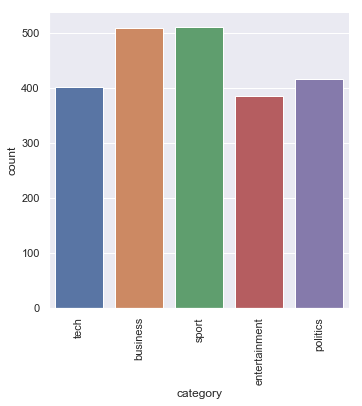

In [9]:
sns.set(font_scale=1)
g = sns.catplot(
            data = df,
            x = "category", 
            kind = "count"
            )
g.set_xticklabels(rotation = 90)

> As can be seen in the distribution, the dependent variable is quite balanced (as balanced as a dataset can be irl). 

## 2.3 Word Cloud

Now, let's build a category-wise word cloud to demonstrate which are the most frequent terms for each of the categories. This will give us a brief idea if there are any frequent words that separate our data up to some extent.

In [10]:
df.category.unique()

array(['tech', 'business', 'sport', 'entertainment', 'politics'],
      dtype=object)

In [11]:
tech = ' '.join(list(df.text[df.category == 'tech']))
business = ' '.join(list(df.text[df.category == 'business']))
sport = ' '.join(list(df.text[df.category == 'sport']))
entertainment = ' '.join(list(df.text[df.category == 'entertainment']))
politics = ' '.join(list(df.text[df.category == 'politics']))

### 2.3.1 Stopwords

* When it comes to NLP, getting rid of stopwords is one of the most important steps. It ensures we get rid of the most frequent but usually useless words, e.g. "the", "a", "an", etc. to eliminate any bias they might cause.
* We have many methods to eliminate stop words - many NLP libraries like sklearn have their own stop words but it is usually considered a good idea to use stop words from the NLTK library. We shall do the same.

In [12]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

### 2.3.2 Word Cloud by Category

Now that we have our stop words in a list, we can build our word clouds.

In [13]:
from wordcloud import WordCloud

def wordcloud(text, title):
    wordcloud = WordCloud(
        width = 1600,
        height = 1000,
        background_color = "black",
        stopwords = stop_words,
        min_font_size = 10
    ).generate(text)

    plt.figure(figsize = (16, 10), facecolor = None) 
    plt.imshow(wordcloud)
    plt.title("Word Cloud for " + title + " Articles\n", fontsize = 20)
    plt.axis("off")
    plt.show()

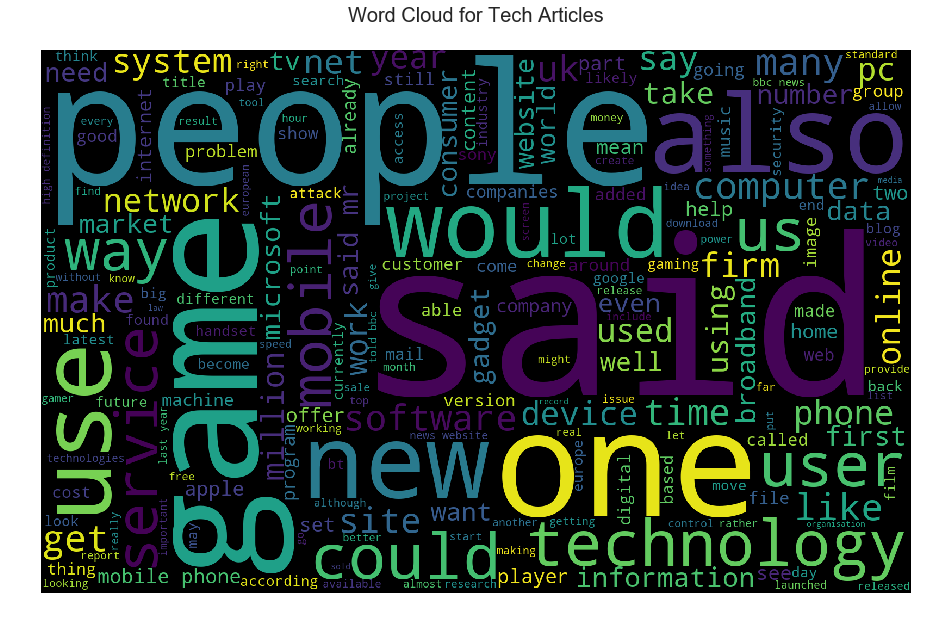

In [14]:
 wordcloud(tech, "Tech")

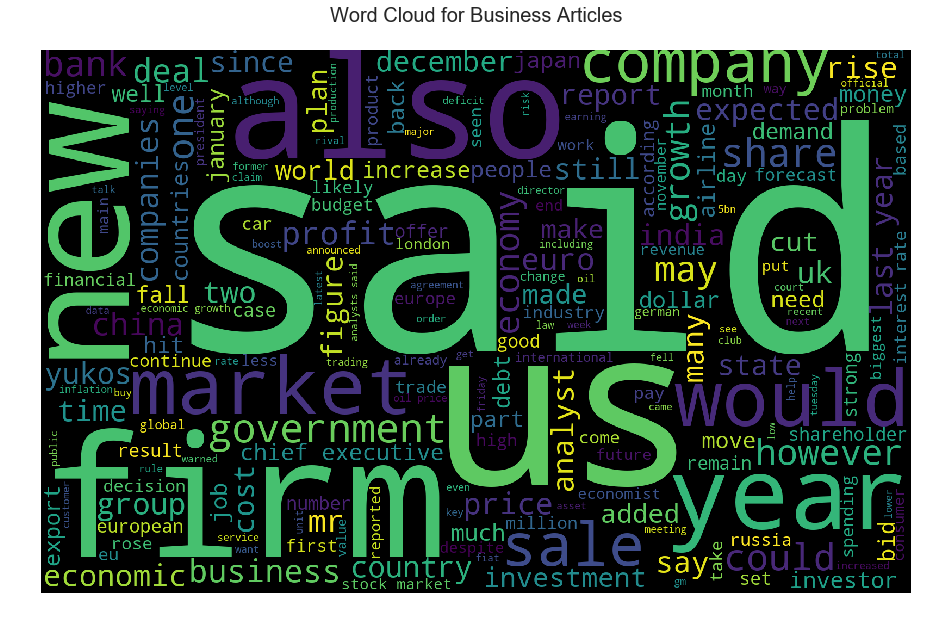

In [15]:
wordcloud(business, "Business")

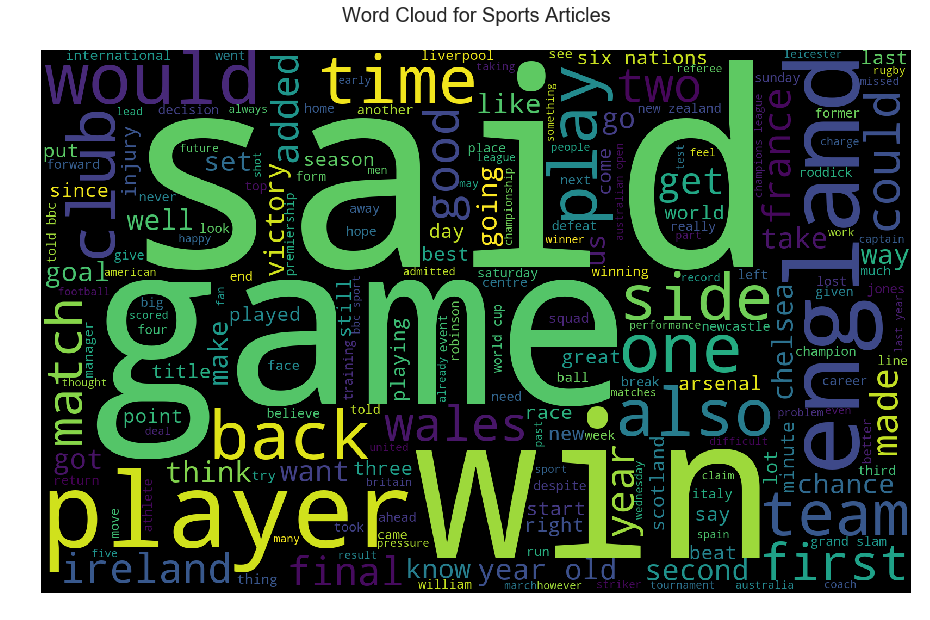

In [16]:
wordcloud(sport, "Sports")

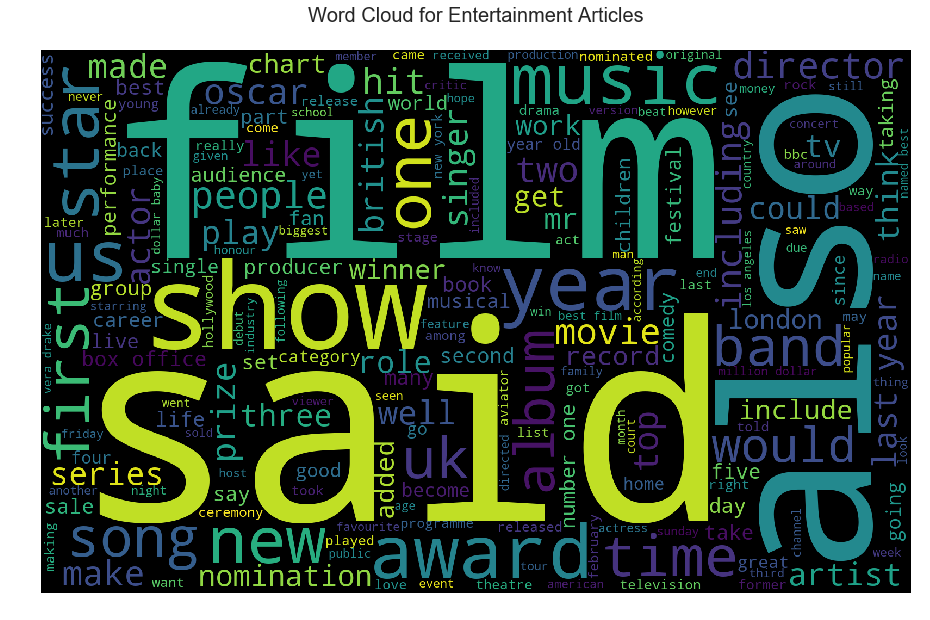

In [17]:
wordcloud(entertainment, "Entertainment")

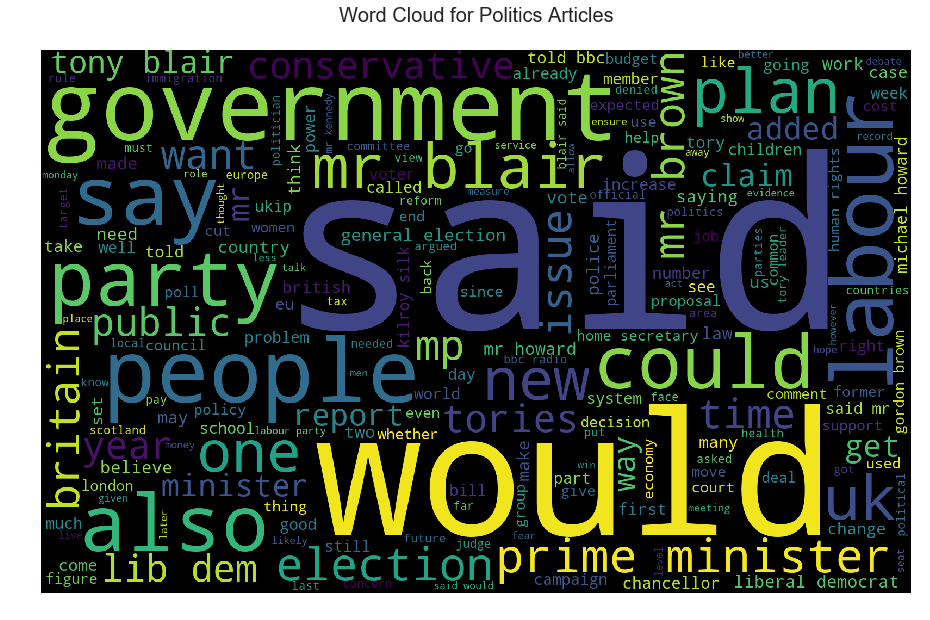

In [18]:
wordcloud(politics, "Politics")

From all of the above word clouds, we make the following observations - 
* The word **"said"** is very frequent in each of the articles In fact it is most frequent in almost every category of article. 
* For **tech** related articles, the words like ***people, technology, computer, software*** are frequent.
* For **business** related articles, the words like ***market, growth, company, firm*** are frequent.
* For **sport** related articles, the words like ***game, match, player, team, win*** are frequent.
* For **entertainment** related articles, the words like ***film, show, music, award, band*** are frequent.
* For **politics** related articles, the words like ***people, plan, labour, government*** are frequent.



One thing that might worry us is that the word **said** is too prevalent in the entire dataset and could lead to some sort of bias. We can be pretty certain that there might not be the case. Why? Because the word is just too prevalent and hence a poor separator of our data. We will verify this in the next step when we will take a look at some of the most relevant words/terms to each of our categories. 

For that purpose, we will adapt a very beautfully written code by Susan Li in [this article](https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f). 

* What we will be doing is using chi-squared test to identify the 2 unigrams and bigrams each that are most relevant to each of the categories. For conducting a chi-squared test, we will need to vectorize our text data first so let's get to it. 

P.S. I have written a more detailed explanation for the above mentioned code for easy understanding below.

## 2.4 Feature Engineering
* When it comes to text data and text analytics in general, feature engineering is converting text data into features which can be used by algorithms i.e. converting text into meaningful numbers. 
* There are many methods to achieve that viz. Tokenization, Vectorization, etc. 
* We will make use of TF-IDF (Term Frequency, Inverse Document Frequency) vectorization to generate features out of our data i.e. the complaints.
* tf-idf vectorization is a technique in which each term in a document and hence the corpus is assigned a weight based on it's frequency. It has two terms.
    1. Term Frequency - This measures the term frequency for each document. 
        > *TF = (number of times term **e** appears in the document) / (total number of words in the document)*
        
    2. Inverse Document Frequency - This measures how important a term is w.r.t. the entire corpus. TF considers all terms equal hence terms which are more frequent like "is", "was", etc. will have a higher TF than more important, but rarer, words like "hazardous", "experiment", etc. IDF scales such rare words up and scales the more frequent words down so as to balance them both.
        > *IDF = ln(number of total documents / number of documents having the term **e**)*
        
    * We then calculate the TF-IDF by simply multiplying both the terms above - 
        > *TF-IDF = TF* x *IDF*

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [138]:
tf_idf = TfidfVectorizer(
    ngram_range=(1, 2), 
    stop_words=stop_words, 
    max_features=100
)

features = tf_idf.fit_transform(df.text).toarray()
features.shape

(2225, 100)

* The number of features generated using tf-idf without using the ***max_features*** argument are almost 370,000 which seems like an overkill for such a small dataset. 
* We will instead use the feature available in the tf-idf transformer to select the top *n* number of features instead.
* We will hence select the top 10,000 features.

In [139]:
features[:5, :5]

array([[0.04134567, 0.        , 0.        , 0.03853465, 0.04563396],
       [0.09410167, 0.        , 0.        , 0.        , 0.10386171],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.29001874],
       [0.        , 0.        , 0.        , 0.        , 0.        ]])

Now that we have our features, let's use that code by Susan to get our 2 most relevant (correlated) unigrams and bigrams for each category.

In [140]:
from sklearn.feature_selection import chi2
N = 2
labels = df.category_id
for category, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tf_idf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(category))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'business':
  . Most correlated unigrams:
. company
. market
  . Most correlated bigrams:
. 
# 'entertainment':
  . Most correlated unigrams:
. best
. film
  . Most correlated bigrams:
. 
# 'politics':
  . Most correlated unigrams:
. blair
. labour
  . Most correlated bigrams:
. 
# 'sport':
  . Most correlated unigrams:
. england
. win
  . Most correlated bigrams:
. 
# 'tech':
  . Most correlated unigrams:
. mobile
. technology
  . Most correlated bigrams:
. 


> * Going through the features above, we can see that almost all of them make a lot of sense. 
> * Also, no mentions of the word **"said"** as discussed above.

#### What the above code does - 
* Line 4 - Here, a loop is run for each of the category using the dictionary of categories and their corresponding category ids which we created earlier. 
* Line 5 - For each category, a chi-squared test is run to check correlation of each feature against the category in question. Remember that the result is a tuple having two arrays - chi2 values and the respective p-values.
* Line 6 - We get the indices of sorted tuple (sorted in ascending order by chi2 values).
* Line 7 - Get the feature list from tf-idf vector created earlier in order of indices created in line 6.
* Line 8, 9 - separate unigrams and bigrams from the features found
* Line 10, 11, 12 - print the two most important unigrams and bigrams for the category in loop.

# 3. Model Selection

We will use the following algorithms to predict the categories and then compare them to select the most suitable one - 

1. Logistic Regression
2. Naive-Bayes Classifier
3. Random Forest

## 3.1 Train-Test Split

We will use a 70-30 train-test split.

In [141]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df['text'], df['category'], train_size = 0.7, random_state = 1)
print("Train Size =", x_train.shape,
      "\nTest Size = ", x_test.shape)

Train Size = (1557,) 
Test Size =  (668,)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


## 3.2 Feature Generation

* For the categories, we will make use of label encoder module to convert them into usable feature.
* We will make use of tf-idf vectorization to generate a sparse matrix out of our text data in order for the algorithms to process it.

In [142]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)

In [143]:
# already imported the tf-idf vectorizer
tf_idf.fit(x_train)

x_train = tf_idf.fit_transform(x_train)
x_test = tf_idf.fit_transform(x_test)

print("Train Size =", x_train.shape,
      "\nTest Size = ", x_test.shape)

Train Size = (1557, 100) 
Test Size =  (668, 100)


## 3.3 Applying Algorithms

* Now that we have our data in order, let's start applying some ML algorithms on it and see how they perform. 
* Since we are not dealing with traditional datasets where the features are comprehensible, here we will not concern ourselves with detailed output from the algorithms (p-values, R-squared, etc.) but simply test their performance and test for it's robustness using cross-validation.

### 3.3.1 Summarizing Model Performance

In [144]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score

naive = MultinomialNB()
logreg = LogisticRegression(random_state = 1)
rf = RandomForestClassifier(n_estimators = 250, random_state = 1)

def model_performance(estimator):
    return cross_val_score(X = x_train, y = y_train, estimator = estimator, cv = 5)
    
cv_result = pd.DataFrame()
cv_result["Model"] = np.repeat(["MultinomialNB", "LogisticRegression", "RandomForestClassifier"], 5)
cv_result["Fold"] = np.tile([1, 2, 3, 4, 5], 3)
cv_result["Accuracy"] = np.concatenate((model_performance(naive), model_performance(logreg), model_performance(rf)))
cv_result

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


,Model,Fold,Accuracy
0,MultinomialNB,1,0.856688
1,MultinomialNB,2,0.853503
2,MultinomialNB,3,0.871383
3,MultinomialNB,4,0.896440
4,MultinomialNB,5,0.834951
5,LogisticRegression,1,0.859873
6,LogisticRegression,2,0.847134
7,LogisticRegression,3,0.877814
8,LogisticRegression,4,0.880259
9,LogisticRegression,5,0.857605


As can be seen, the accuracy scores have been pretty consistent across all folds for all three of our algorithms. Let's calculate the mean accuracy for each model and chse the best one to make some predictions.

### 3.3.2 Model Selection

In [147]:
cv_result.groupby("Model").Accuracy.mean().sort_values(ascending = False)

Model
RandomForestClassifier    0.874087
LogisticRegression        0.864537
MultinomialNB             0.862593
Name: Accuracy, dtype: float64

As we can see, Random Forest seems to be performing the best out of the three. Logistic Regression and Multinomial Naive-Bayes are almost just as good as Random Forest as they only fall short by 1%. We will now move ahead with Random Forest to make some predictions and see the confusion matrix as well.

### 3.3.3 Predictions

In [151]:
rf.fit(x_train, y_train)
predictions = rf.predict(x_test)

pred_df = pd.DataFrame()
pred_df["Actual"] = y_test
pred_df["Predicted"] = predictions
pred_df.head(10)

,Actual,Predicted
0,3,2
1,2,2
2,3,3
3,0,0
4,4,3
5,1,1
6,0,2
7,3,3
8,1,1
9,4,4


### 3.3.4 Confusion Matrix

In [152]:
from pandas_ml import ConfusionMatrix
cm = ConfusionMatrix(y_test, predictions)
cm
cm.print_stats()

Confusion Matrix:

Predicted    0    1    2    3    4  __all__
Actual                                     
0          115    4   27    8   14      168
1            4   94    0    8    2      108
2           11    0   96    7    5      119
3            3    7    2  137    5      154
4            5    3    6    4  101      119
__all__    138  108  131  164  127      668


Overall Statistics:

Accuracy: 0.812874251497006
95% CI: (0.7811907345507607, 0.8417628972917456)
No Information Rate: ToDo
P-Value [Acc > NIR]: 9.656752206546179e-209
Kappa: 0.7650653596610189
Mcnemar's Test P-Value: ToDo


Class Statistics:

Classes                                       0         1          2  \
Population                                  668       668        668   
P: Condition positive                       168       108        119   
N: Condition negative                       500       560        549   
Test outcome positive                       138       108        131   
Test outcome negative  

C:\ProgramData\Anaconda3\lib\site-packages\pandas_ml\confusion_matrix\stats.py:60: FutureWarning: supplying multiple axes to axis is deprecated and will be removed in a future version.
  num = df[df > 1].dropna(axis=[0, 1], thresh=1).applymap(lambda n: choose(n, 2)).sum().sum() - np.float64(nis2 * njs2) / n2


In [162]:
cm.stats()['overall']

OrderedDict([('Accuracy', 0.812874251497006),
             ('95% CI', (0.7811907345507607, 0.8417628972917456)),
             ('No Information Rate', 'ToDo'),
             ('P-Value [Acc > NIR]', 9.656752206546179e-209),
             ('Kappa', 0.7650653596610189),
             ("Mcnemar's Test P-Value", 'ToDo')])

We can now conclude that - 

>***Cross-Validation method used*** >>> **5-Fold Cross Validation**  
>***Training Set Accuracy*** >>> **87 %**  
>***Testing Set Accuracy*** >>> **81 %**

Hence, we can safely accept the Random Forest model as best model for future predictions.

In [165]:
df['text'][0]

'tv future in the hands of viewers with home theatre systems  plasma high-definition tvs  and digital video recorders moving into the living room  the way people watch tv will be radically different in five years  time.  that is according to an expert panel which gathered at the annual consumer electronics show in las vegas to discuss how these new technologies will impact one of our favourite pastimes. with the us leading the trend  programmes and other content will be delivered to viewers via home networks  through cable  satellite  telecoms companies  and broadband service providers to front rooms and portable devices.  one of the most talked-about technologies of ces has been digital and personal video recorders (dvr and pvr). these set-top boxes  like the us s tivo and the uk s sky+ system  allow people to record  store  play  pause and forward wind tv programmes when they want.  essentially  the technology allows for much more personalised tv. they are also being built-in to high